In [2]:
#import sympy
import scanpy as sc
import scanpy.external as sce
import pandas as pd
from scipy.io import mmread
import harmonypy as hm
import numpy as np
import matplotlib.pyplot as plt
import scvi
import seaborn as sns

sc.settings.verbosity = 3
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/home/yc/.local/lib/python3.10/site-packages/scvi/_settings.py:63: UserWarning: Since v1.0.0, scvi-tools no longer uses a random seed by default. Run `scvi.settings.seed = 0` to reproduce results from previous versions.
  self.seed = seed
/home/yc/.local/lib/python3.10/site-packages/scvi/_settings.py:70: UserWarning: Setting `dl_pin_memory_gpu_training` is deprecated in v1.0 and will be removed in v1.1. Please pass in `pin_memory` to the data loaders instead.
  self.dl_pin_memory_gpu_training = (
/home/yc/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/yc/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.24.4 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.14.0 python-igraph==0.10.6 pynndescent==0.5.10


In [2]:
# Construct an object using 10x data
# Replace these paths with the actual paths to the four files
matrix_file = 'example/data/'  # Update to the directory containing the matrix files
barcodes_file = 'example/data/barcodes.tsv'
genes_file = 'example/data/genes.tsv'
metadata_file = 'example/data/metadata.csv.zip'

# Check the head of the metadata
metadata_head = pd.read_csv(metadata_file, compression='zip', nrows=5)
print(metadata_head)

# Read 10x Genomics data using Scanpy
adata = sc.read_10x_mtx(matrix_file, var_names='gene_symbols', cache=True)

# Read additional metadata
metadata = pd.read_csv(metadata_file, compression='zip', index_col='Unnamed: 0')

# Update AnnData with barcodes, genes, and additional metadata
adata.obs_names = pd.read_csv(barcodes_file, header=None, names=['CellID']).squeeze()
adata.var_names = pd.read_csv(genes_file, sep='\t', header=None, names=['GeneID', 'GeneSymbol'], index_col=0)['GeneSymbol']
adata.obs = metadata.loc[adata.obs_names]

# Save AnnData object
adata.write('adata.h5ad')

# Print the AnnData object
print(adata)

            Unnamed: 0 PatientID  NormalvsTumor
0  GCGACCACAAGCTGTT-11        P3              0
1  CTAATGGAGTCCGTAT-49       P12              1
2  ACGCAGCCAGAGTGTG-29        P7              1
3   GTTCATTAGTTGCAGG-9        P2              1
4  ATCGAGTCAATGTTGC-18        P4              1
... reading from cache file cache\example-data-matrix.h5ad
AnnData object with n_obs × n_vars = 4276224 × 33694
    obs: 'PatientID', 'NormalvsTumor'
    var: 'gene_ids'


/home/yc/.local/lib/python3.10/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


normalizing counts per cell


/home/yc/miniconda3/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


    finished (0:00:00)


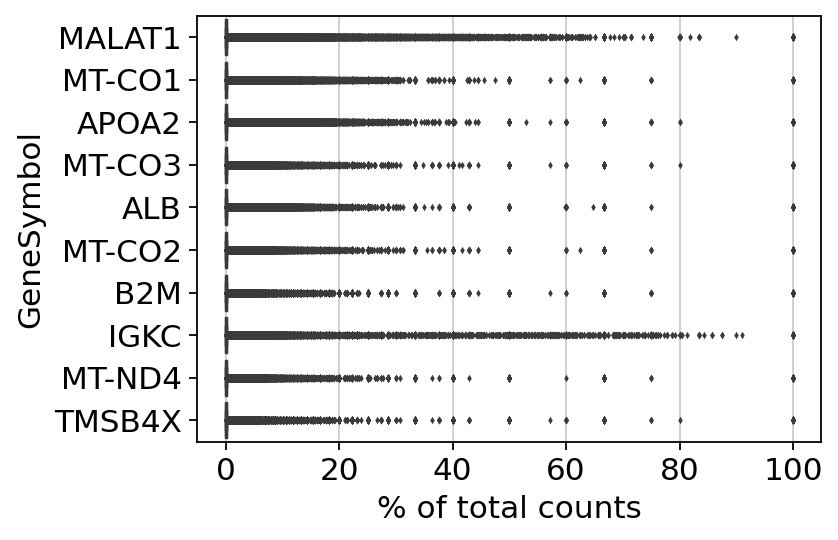

AnnData object with n_obs × n_vars = 4276224 × 33694
    obs: 'PatientID', 'NormalvsTumor'
    var: 'gene_ids'

In [2]:
# Read the adata object
adata = sc.read('adata.h5ad')
sc.pl.highest_expr_genes(adata, n_top=10) 
adata

filtered out 4264933 cells that have less than 200 genes expressed
filtered out 13431 genes that are detected in less than 3 cells


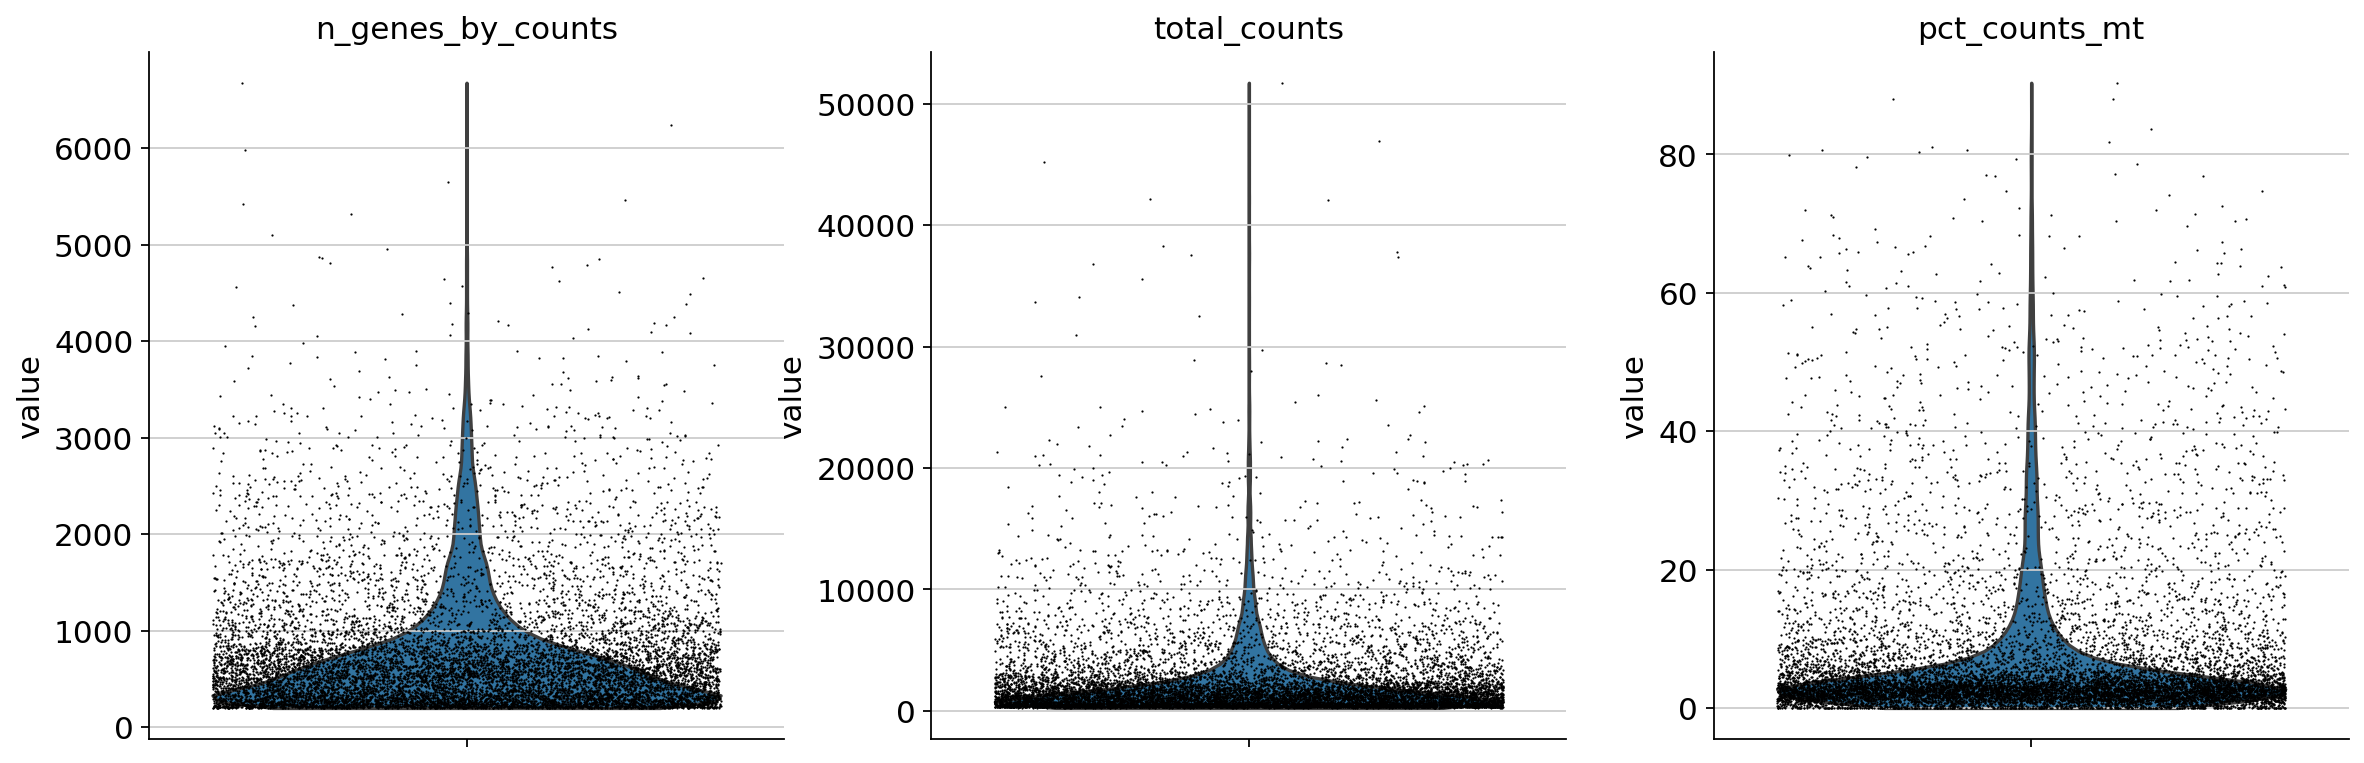

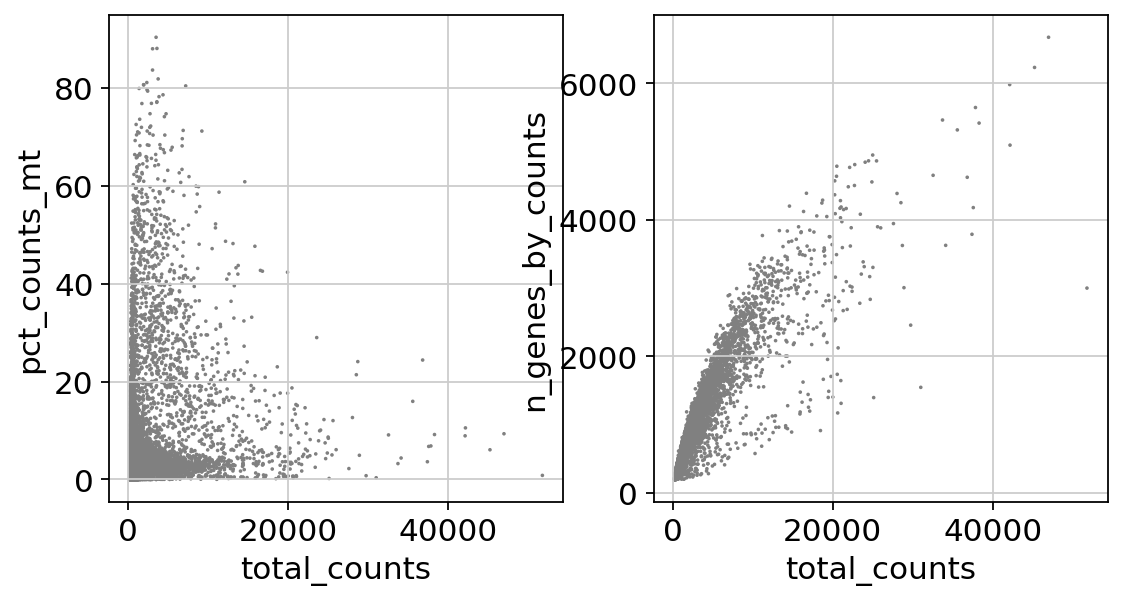

In [3]:
# Basic quanlity check and filtering
adata.var_names_make_unique()

# Basic filtering:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

# Calculate mt gene percentages
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

# Plot violin plots
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

# Draw scatter plots
fig, axes = plt.subplots(1, 2, figsize=(8, 4))  # Adjust the figsize as needed
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', ax=axes[0], show=False)
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', ax=axes[1], show=False)
plt.show()

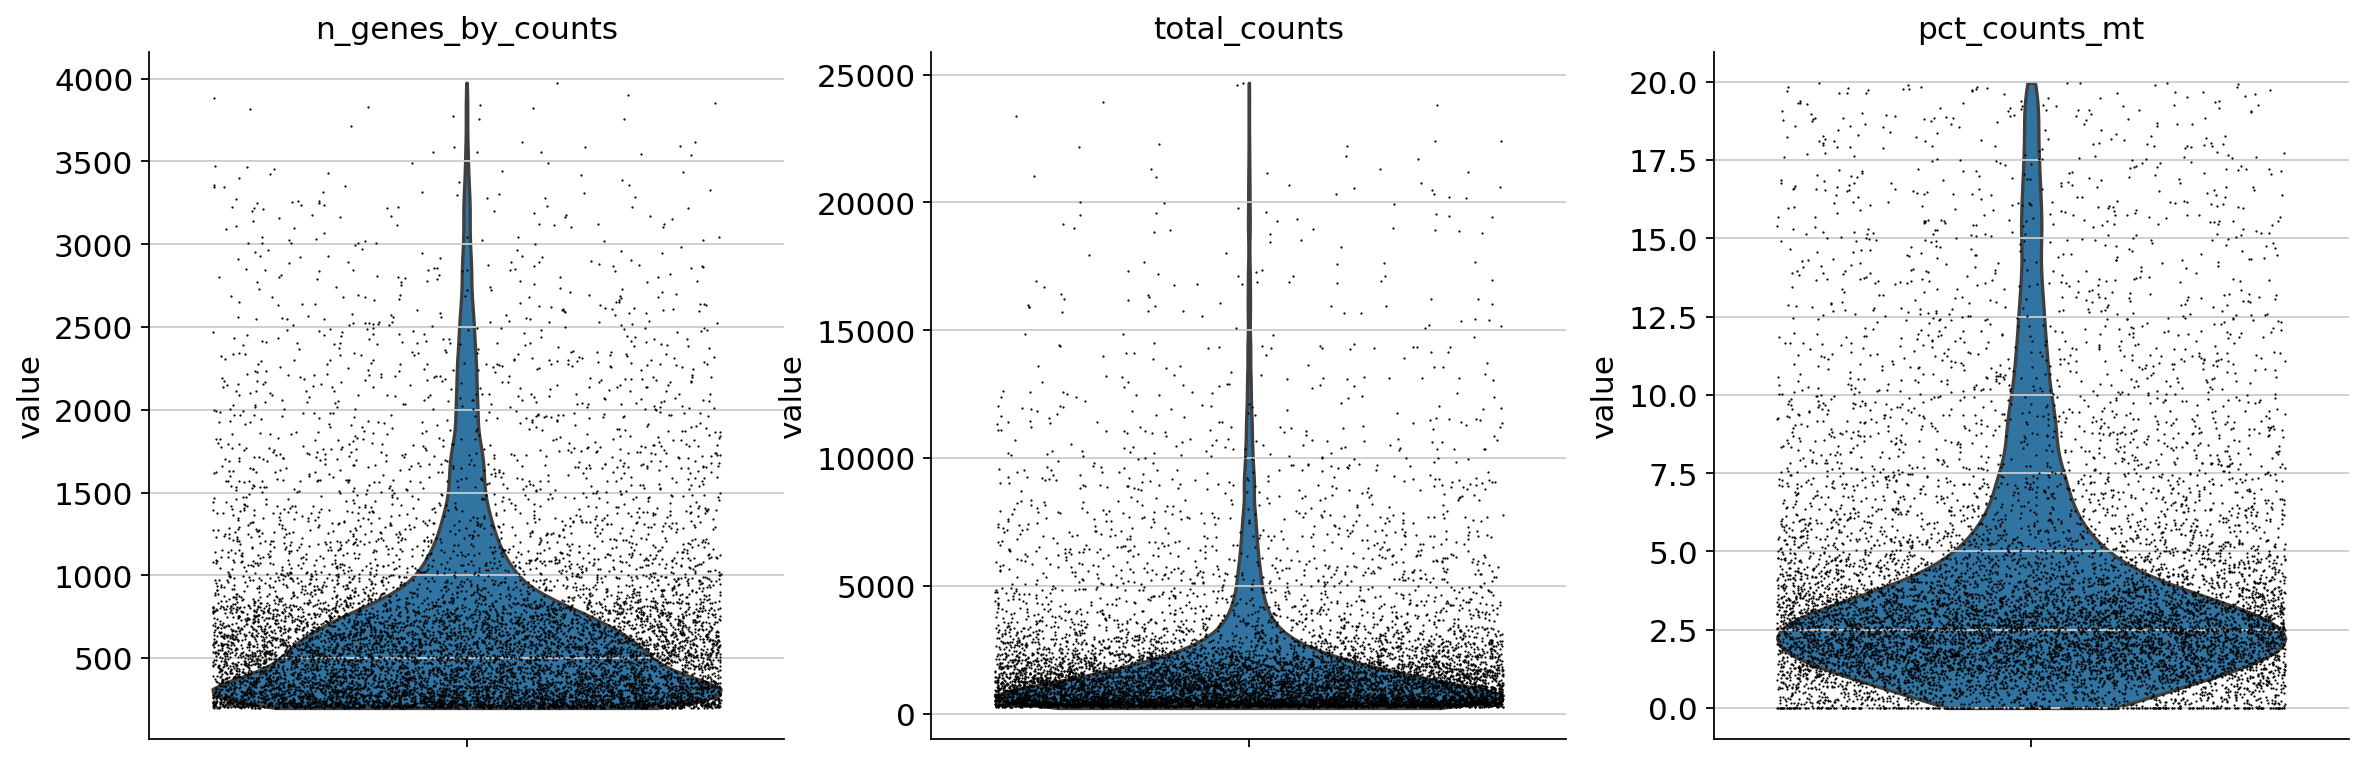

In [4]:
# Manual filtering
adata = adata[adata.obs.n_genes_by_counts < 4000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]
adata = adata[adata.obs.total_counts < 25000,:]

# view again
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

normalizing counts per cell
    finished (0:00:00)


/home/yc/miniconda3/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


/home/yc/miniconda3/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:62: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


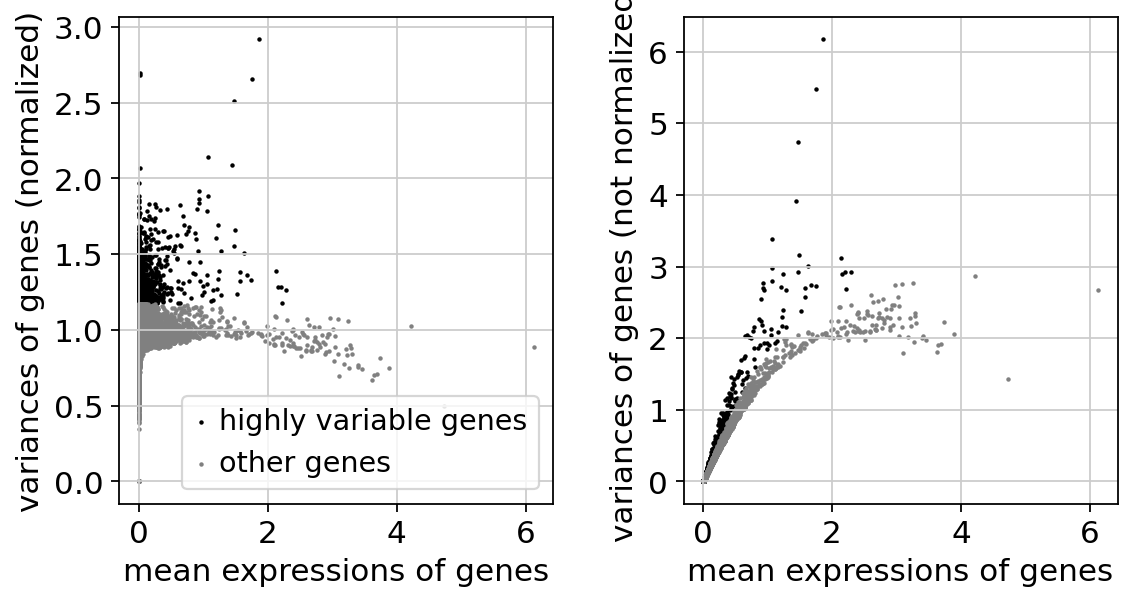

In [5]:
# Generate the PCA
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=2000)
sc.pl.highly_variable_genes(adata)

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use
    finished (0:19:47)
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:09)


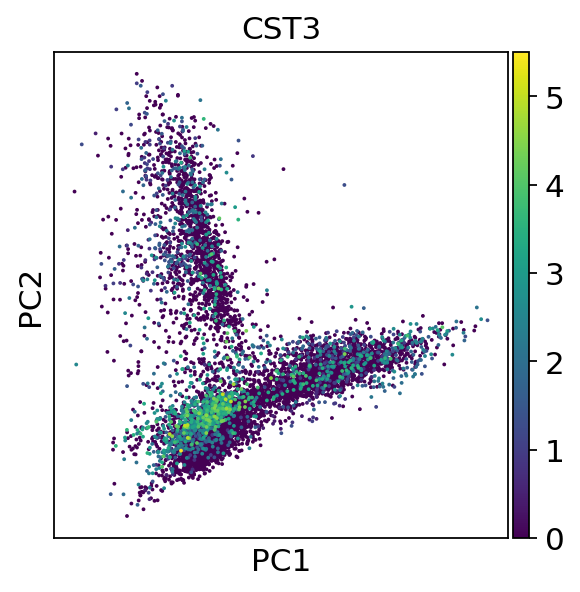

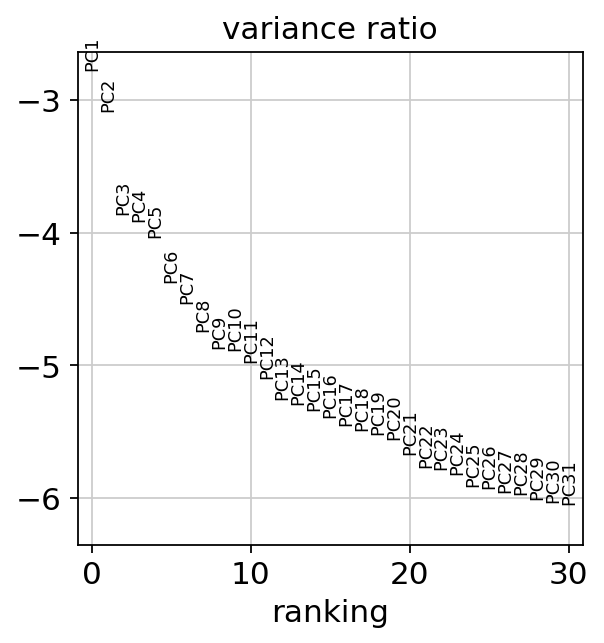

In [6]:
adata.raw = adata
# Regress Out Unwanted Sources of Variation before scaling
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])

# Scale using the parallel backend
#adata.X = adata.X.toarray()  # Ensure data is dense for parallel scaling
#adata = adata.parallelize(adata.uns['neighbors']['params']['n_jobs'])
#adata.X = adata.X.astype('float32', copy=False)
sc.pp.scale(adata, max_value=10)

sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca(adata, color='CST3')
sc.pl.pca_variance_ratio(adata, log=True)

In [7]:
# Save AnnData object
adata.write('adata2.h5ad')

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:17)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)


/home/yc/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yc/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


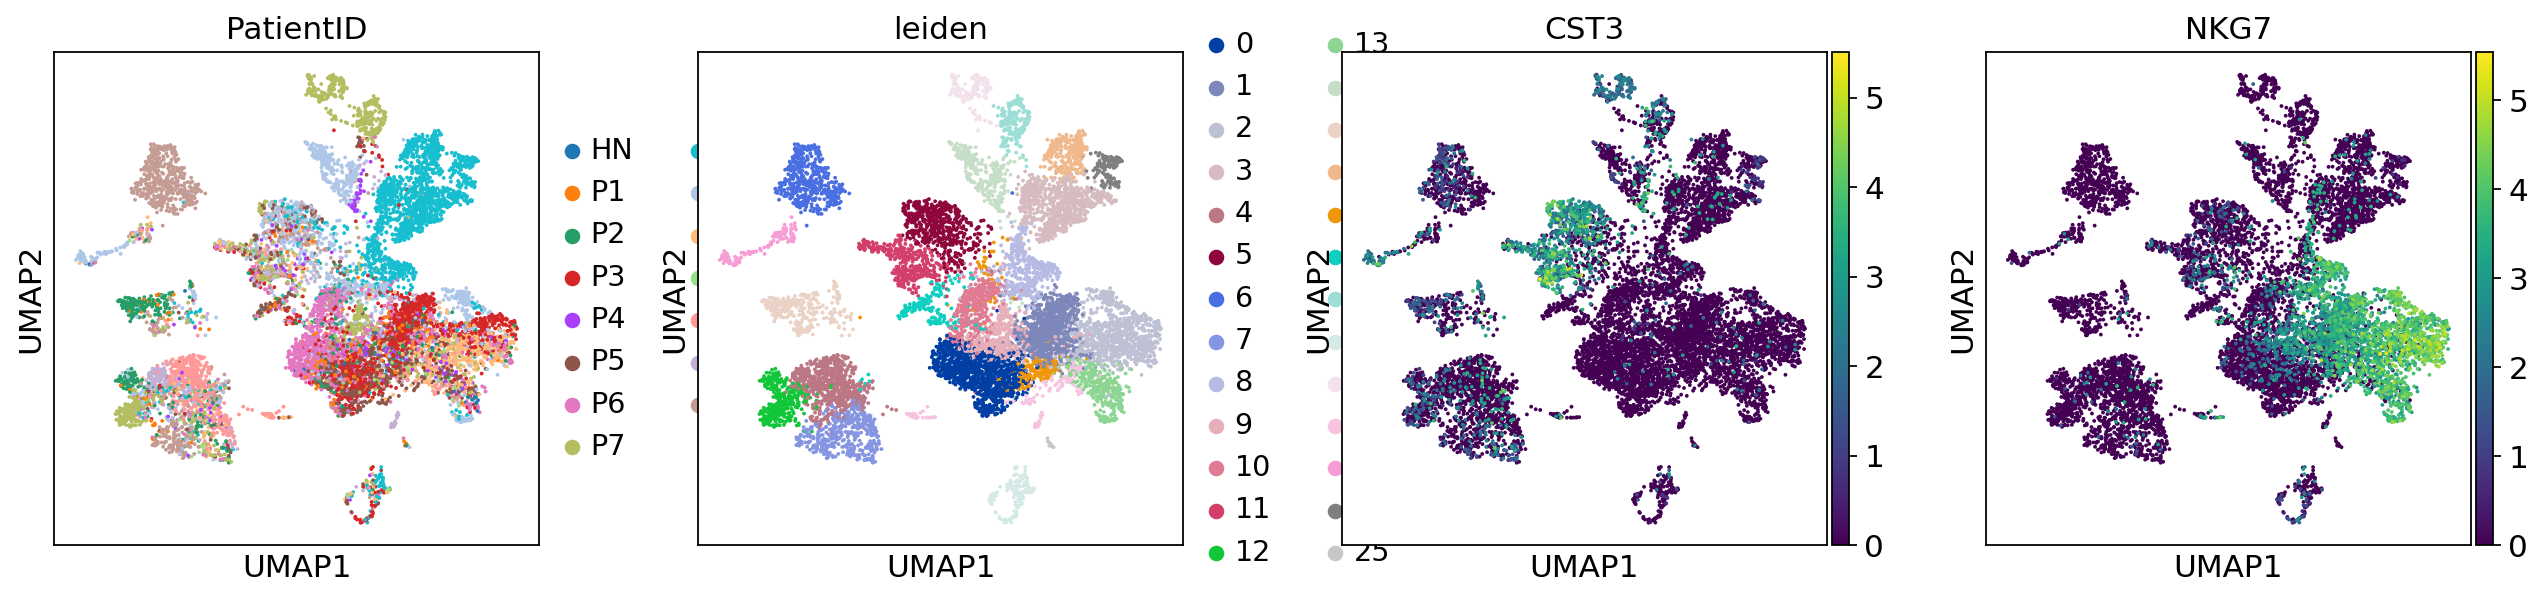

In [8]:
# Generate the umap
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

#Embedding the neighborhood graph
sc.tl.leiden(adata)  # required by the following paga function
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

sc.pl.umap(adata, color=['PatientID', 'leiden', 'CST3', 'NKG7'])
## sc.pl.umap(adata, color=['CST3', 'NKG7', 'PatientID'], use_raw=False)

# Save the result.
adata.write('adata3.h5ad')

In [9]:
# Read the adata object
adata = sc.read('adata3.h5ad')
adata

AnnData object with n_obs × n_vars = 10203 × 20263
    obs: 'PatientID', 'NormalvsTumor', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'PatientID_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

2023-12-03 17:28:37,085 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-12-03 17:28:57,207 - harmonypy - INFO - sklearn.KMeans initialization complete.
2023-12-03 17:28:57,287 - harmonypy - INFO - Iteration 1 of 10
2023-12-03 17:29:18,306 - harmonypy - INFO - Iteration 2 of 10
2023-12-03 17:29:41,316 - harmonypy - INFO - Iteration 3 of 10
2023-12-03 17:30:06,626 - harmonypy - INFO - Iteration 4 of 10
2023-12-03 17:30:35,051 - harmonypy - INFO - Iteration 5 of 10
2023-12-03 17:30:53,200 - harmonypy - INFO - Converged after 5 iterations


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:07)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


/home/yc/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yc/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


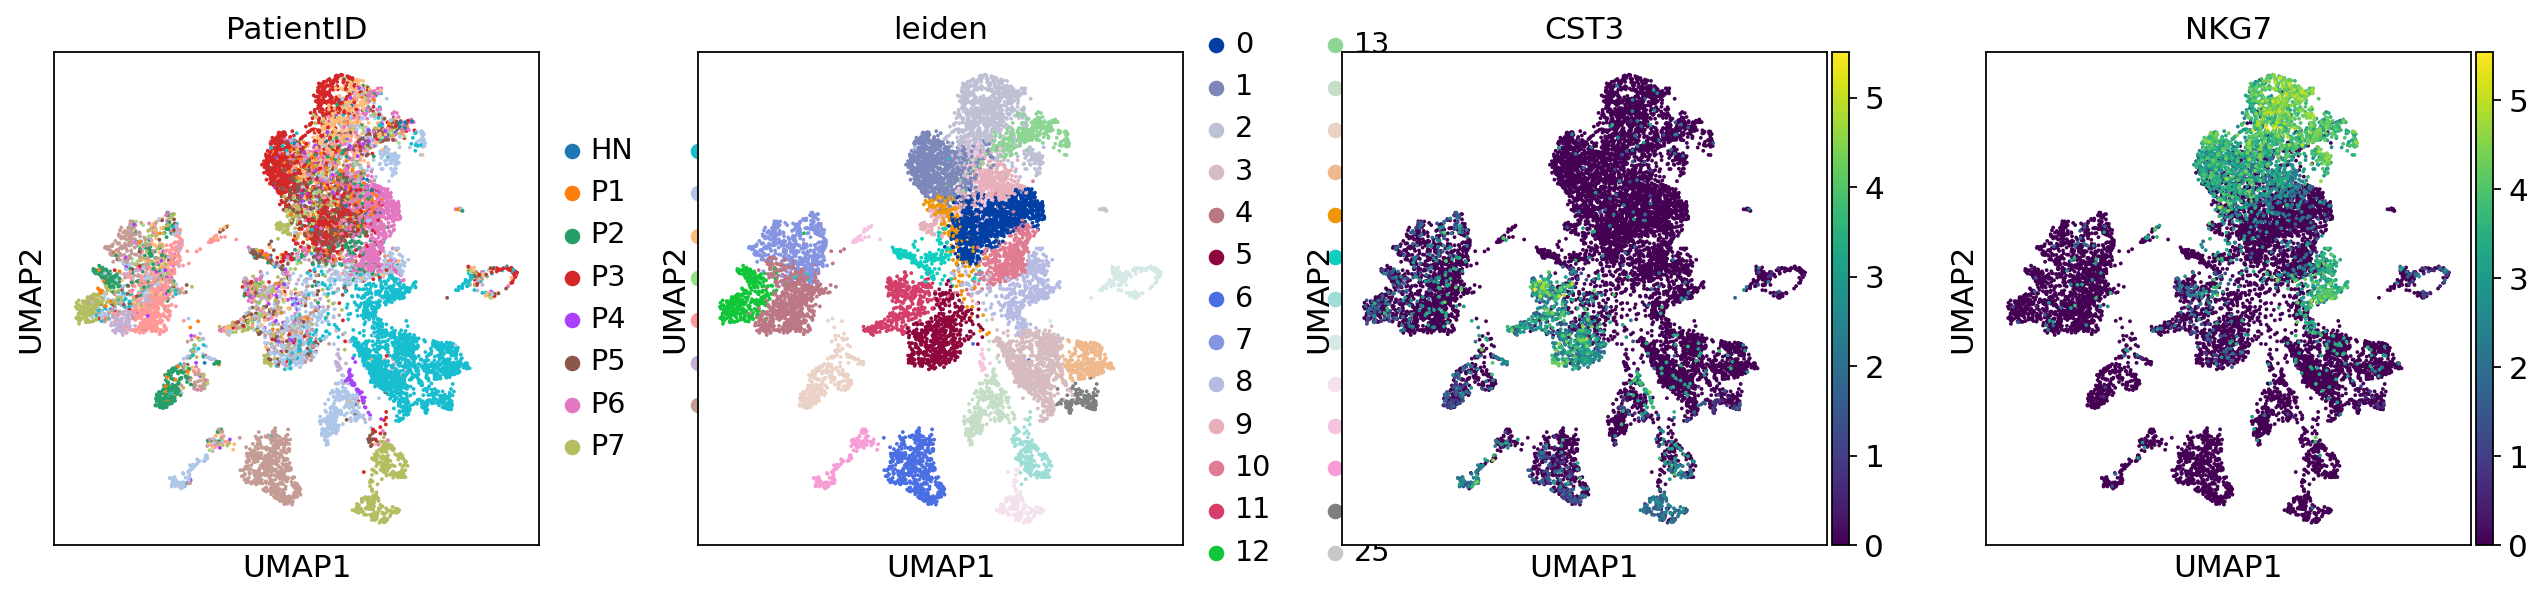

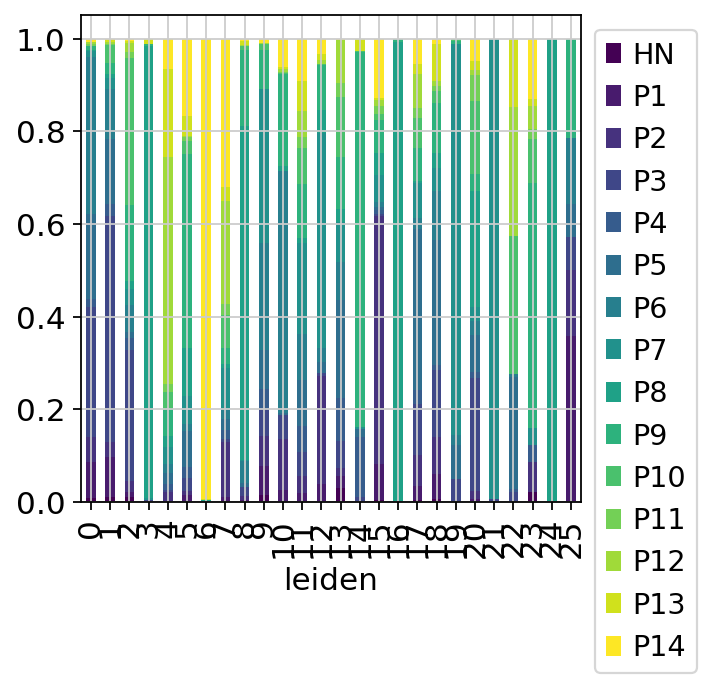

In [27]:
# Batch correction option: Harmony
adata = sc.read('adata3.h5ad')
sce.pp.harmony_integrate(adata, 'PatientID')
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['PatientID', 'leiden', 'CST3', 'NKG7'])

#Stacked plot of the batch proportions among clusters
df = pd.crosstab(index=adata.obs['leiden'], columns=adata.obs['PatientID'], normalize='index')
ax = df.plot(kind='bar', stacked=True, cmap='viridis')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:08)
running Leiden clustering
    finished: found 15 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:11)


/home/yc/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yc/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


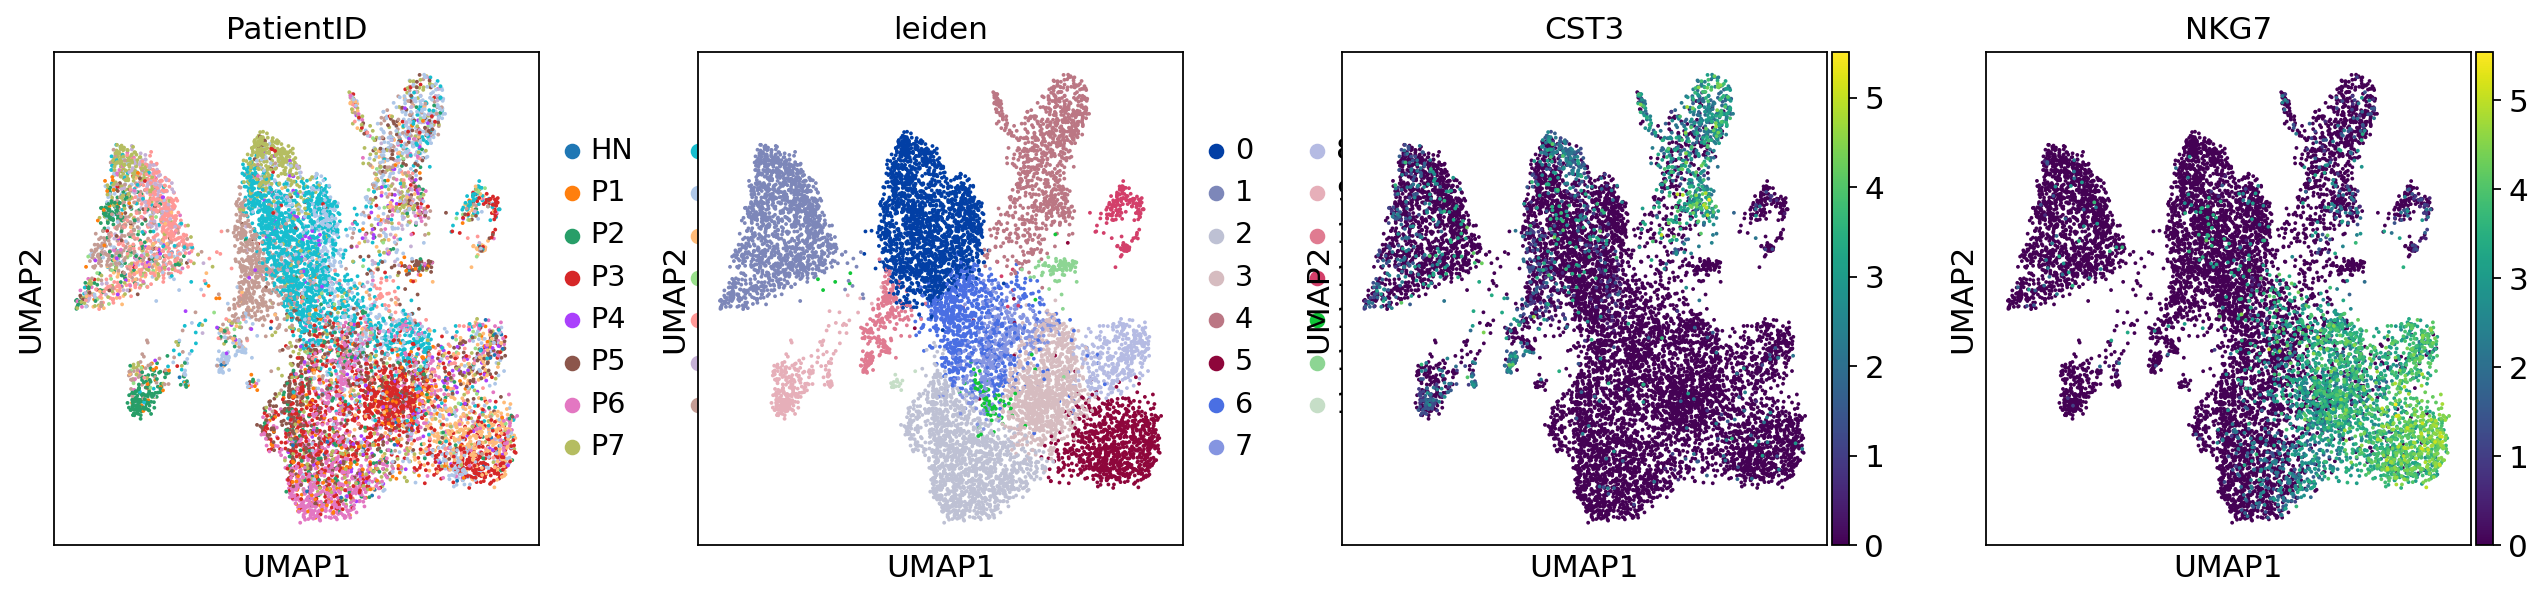

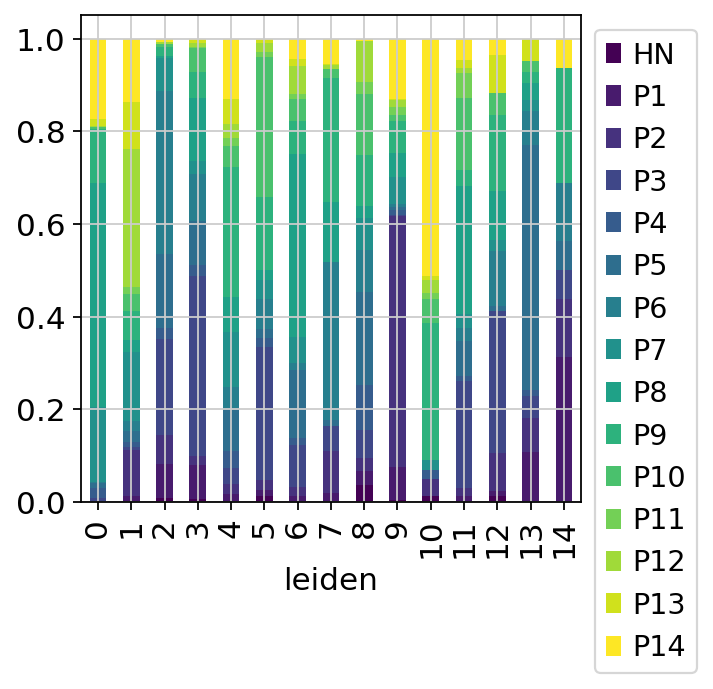

In [25]:
# Batch correction option: bbknn
# The best for this data object
adata = sc.read('adata3.h5ad')
sce.pp.bbknn(adata, 'PatientID')
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['PatientID', 'leiden', 'CST3', 'NKG7'])

#Stacked plot of the batch proportions among clusters
df = pd.crosstab(index=adata.obs['leiden'], columns=adata.obs['PatientID'], normalize='index')
ax = df.plot(kind='bar', stacked=True, cmap='viridis')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:06)
running Leiden clustering
    finished: found 26 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


/home/yc/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/yc/miniconda3/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


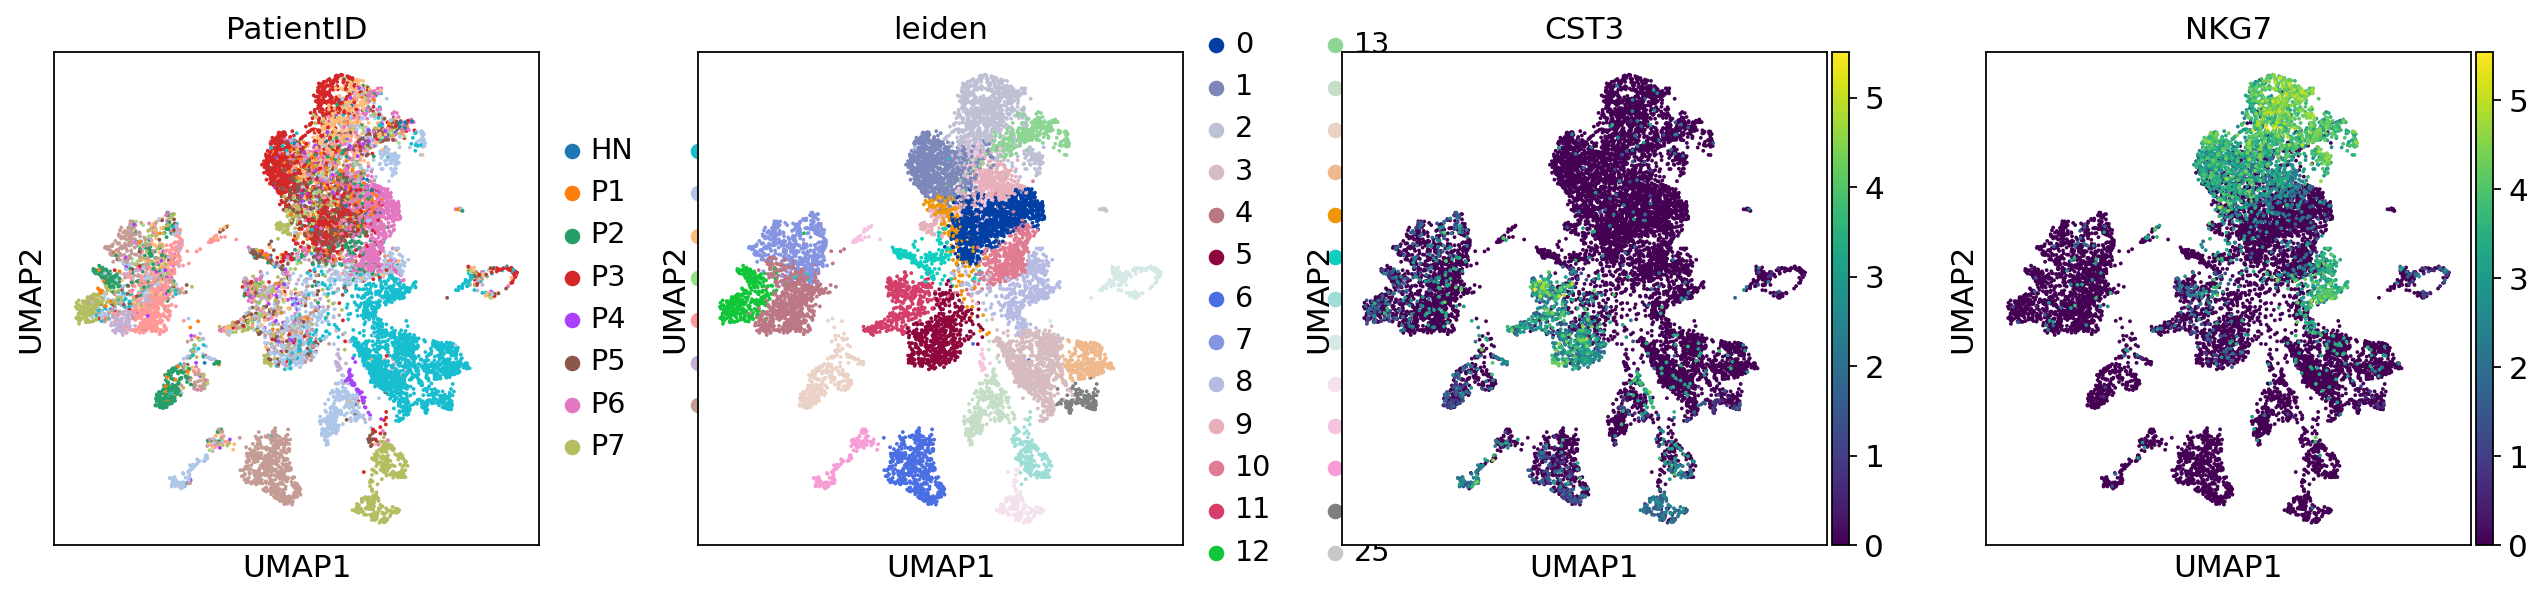

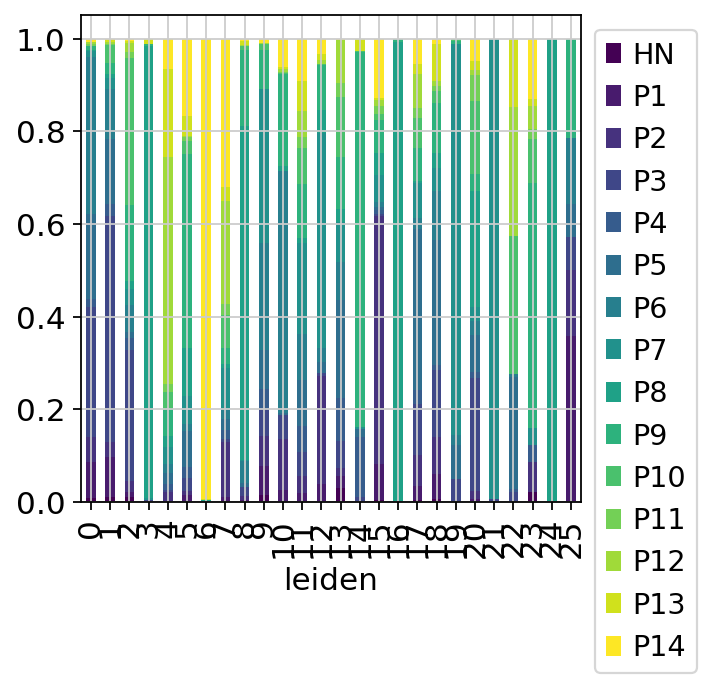

In [24]:
# Batch correction option: scanorama
adata = sc.read('adata3.h5ad')
sce.pp.mnn_correct(adata, batch_key='PatientID')
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['PatientID', 'leiden', 'CST3', 'NKG7'])

#Stacked plot of the batch proportions among clusters
df = pd.crosstab(index=adata.obs['leiden'], columns=adata.obs['PatientID'], normalize='index')
ax = df.plot(kind='bar', stacked=True, cmap='viridis')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [3]:
#scvi tool
adata = sc.read('adata3.h5ad')
adata
sc.pl.umap(adata, color=['PatientID'], wspace=0.5)
adata.layers["counts"] = adata.X.copy()
# Set up your AnnData object
sc.pp.filter_cells(adata, min_genes=3)
scvi.model.SCVI.setup_anndata(adata, batch_key="PatientID") # layer="counts", 

# Create the SCVI model
vae = scvi.model.SCVI(adata, n_layers=2, n_latent=30, gene_likelihood="nb")

# Train the VAE model
vae.train(max_epochs=100)

AnnData object with n_obs × n_vars = 10203 × 20263
    obs: 'PatientID', 'NormalvsTumor', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden'
    var: 'gene_ids', 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'PatientID_colors', 'hvg', 'leiden', 'leiden_colors', 'leiden_sizes', 'log1p', 'neighbors', 'paga', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'